# Plot data distribution 

##  Naive start: $\mathbb{P}_{\text{data}}$

As said, simply plot how the steering, acceleration (brake and throttle), and commands are distributed with a normal driving dataset in Town01:

In [2]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from glob import glob
import click
from multiprocessing import Pool

/home/dporres/miniconda3/envs/cilv2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/dporres/miniconda3/envs/cilv2/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


In [3]:
def get_data(data_file):
    """ Get the data from a single data file """
    with open(data_file, 'r') as f:
        data = json.load(f)
    return data

In [4]:
os.getcwd()

'/run/user/1001/gvfs/sftp:host=158.109.8.151,port=22345/datafast/experiments/dporres/CILv2_multiview'

In [5]:
# The smallest dataset in Town01
dataset_dir = os.path.join('/run/user/1001/gvfs/sftp:host=158.109.8.151,port=22345', 'datatmp', 'Datasets', 'yixiao', 
                           'CARLA', 'Roach_carla0913_fps10', 'Roach_carla0913_fps10_dense_normalcamera_T1_dense_3cam')

In [6]:
data_files = glob(os.path.join(dataset_dir, '**', 'cmd_fix_can_bus*.json'), recursive=True)

In [7]:
len(data_files)

45000

In [8]:
# Extract the data from all the files
with Pool(os.cpu_count() * 2) as pool:
    data = list(tqdm(pool.imap(get_data, data_files), total=len(data_files)))

  0%|          | 0/45000 [00:00<?, ?it/s]

100%|██████████| 45000/45000 [00:54<00:00, 825.03it/s] 


In [9]:
import pandas as pd

In [10]:
df = pd.DataFrame(data)

In [11]:
df.head()

,acceleration,brake,direction,ego_position,speed,steer,throttle
0,0.919805,0.000000,4.0,"[88.16416588433295, 288.3071579665522, 0.03499...",5.336511e+00,-0.046701,0.919805
1,-0.631200,0.631200,4.0,"[338.9181009033901, 161.59055572072577, 0.0337...",-7.069047e-10,-0.011484,0.000000
2,-0.331702,0.331702,4.0,"[209.14548978347833, 55.2344045616818, 0.03376...",5.177109e-10,-0.023917,0.000000
3,-0.451861,0.451861,4.0,"[338.7806546275531, 74.95403791874006, 0.03375...",9.002691e-09,0.169315,0.000000
4,1.000000,0.000000,3.0,"[338.75445093438486, 212.23331384612803, 0.033...",4.408150e-01,0.008703,1.000000


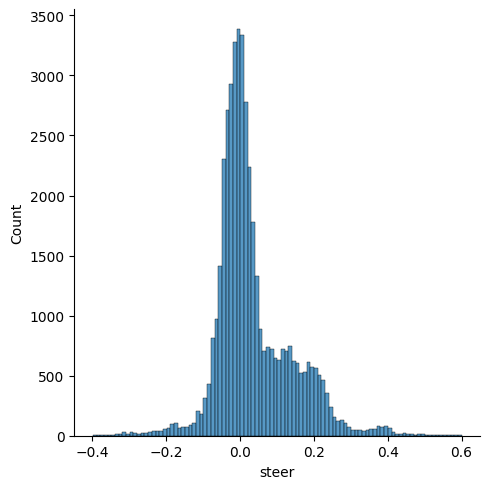

In [12]:
# Plot the distribution of the steering angle
sns.displot(df['steer'], kde=False, bins=100)
plt.show()

In [13]:
# Nice, let's add a column indicating the command with a string
command_dict = {1.0: 'Turn Left', 2.0: 'Turn Right', 3.0: 'Go Straight', 4.0: 'Follow Lane'}
df['command'] = df['direction'].map(command_dict)

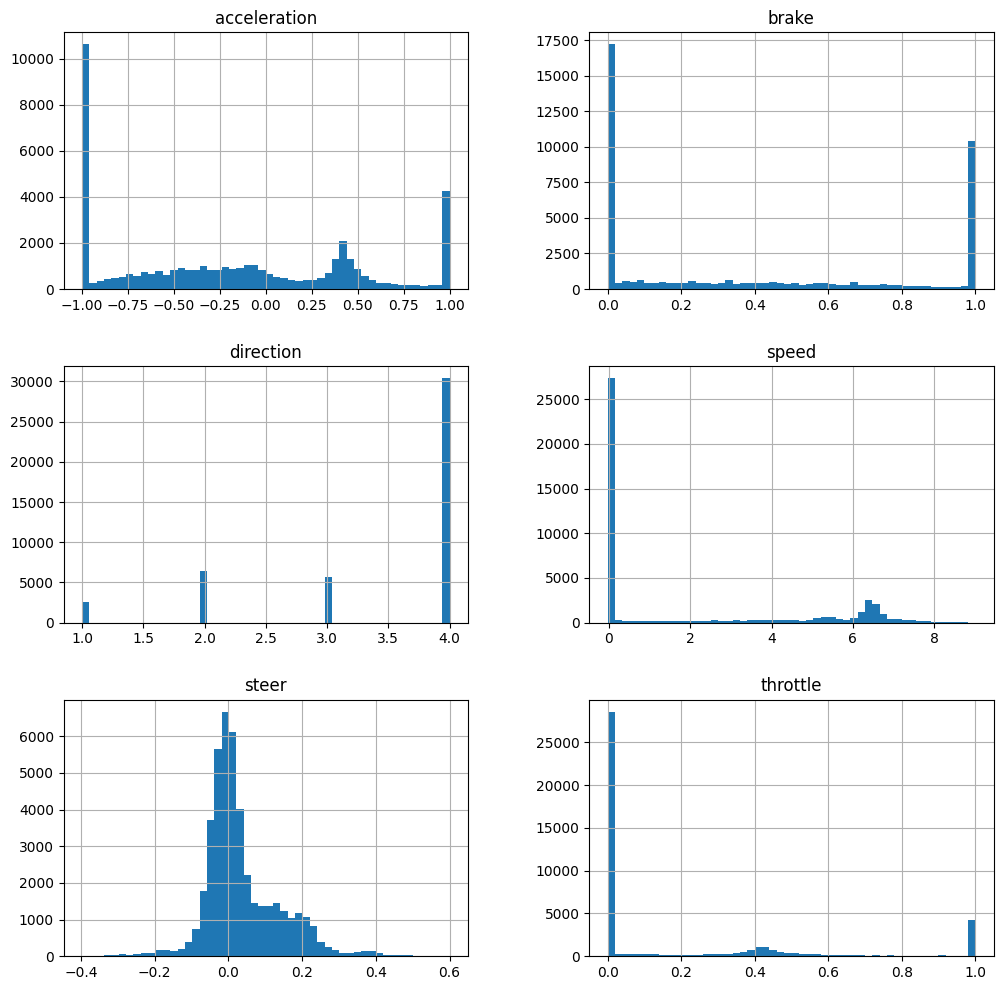

In [14]:
# Plot the distribution of all columns in the dataset
df.hist(figsize=(12, 12), bins=50)
plt.show()

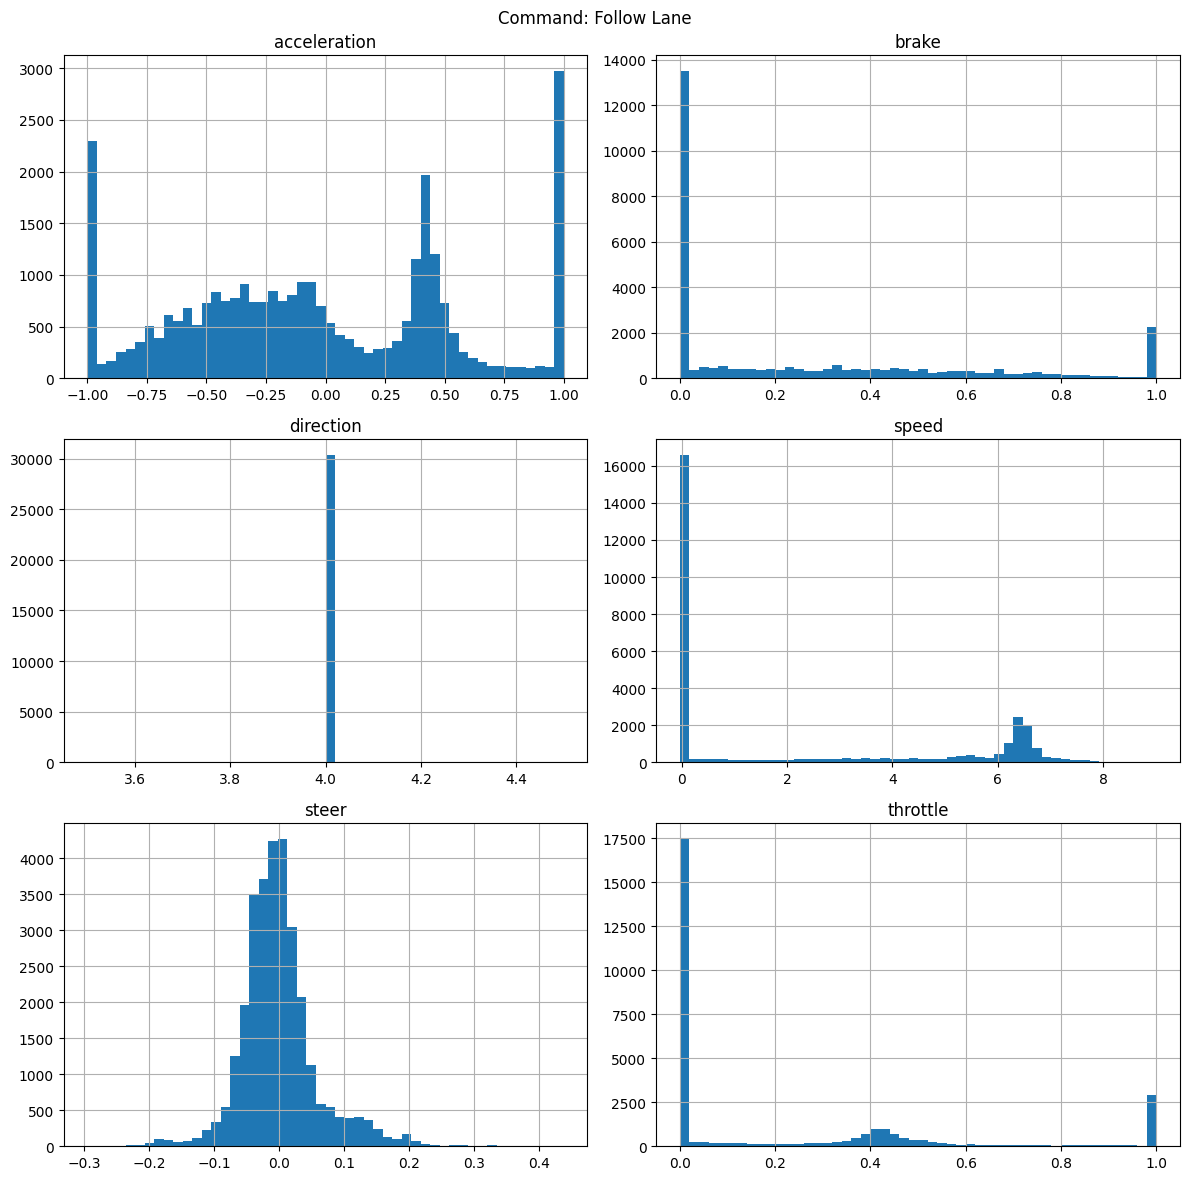

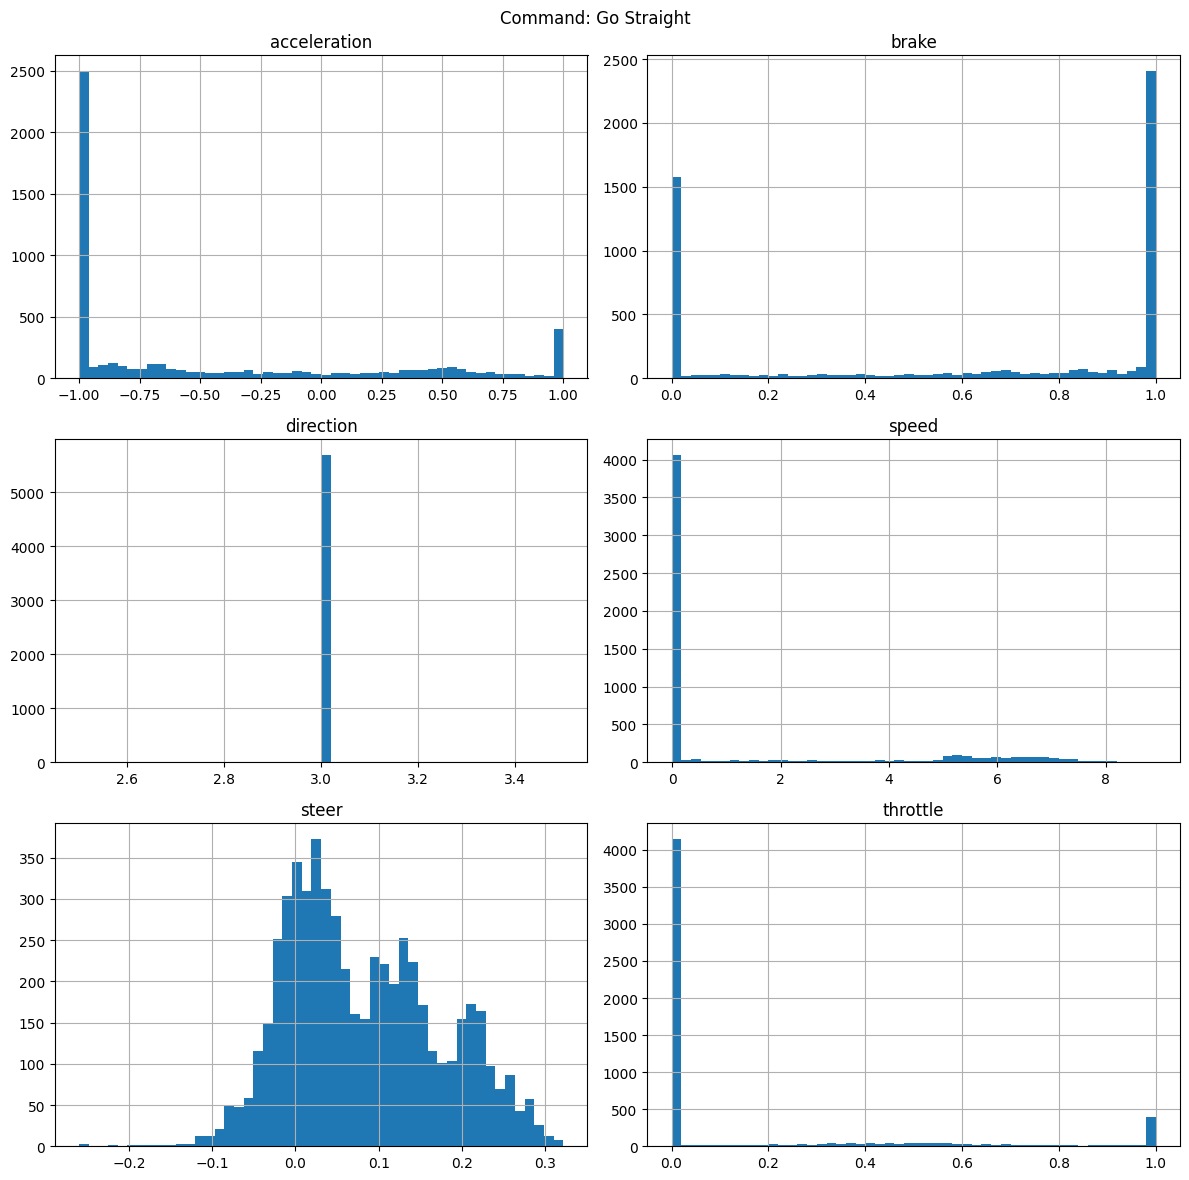

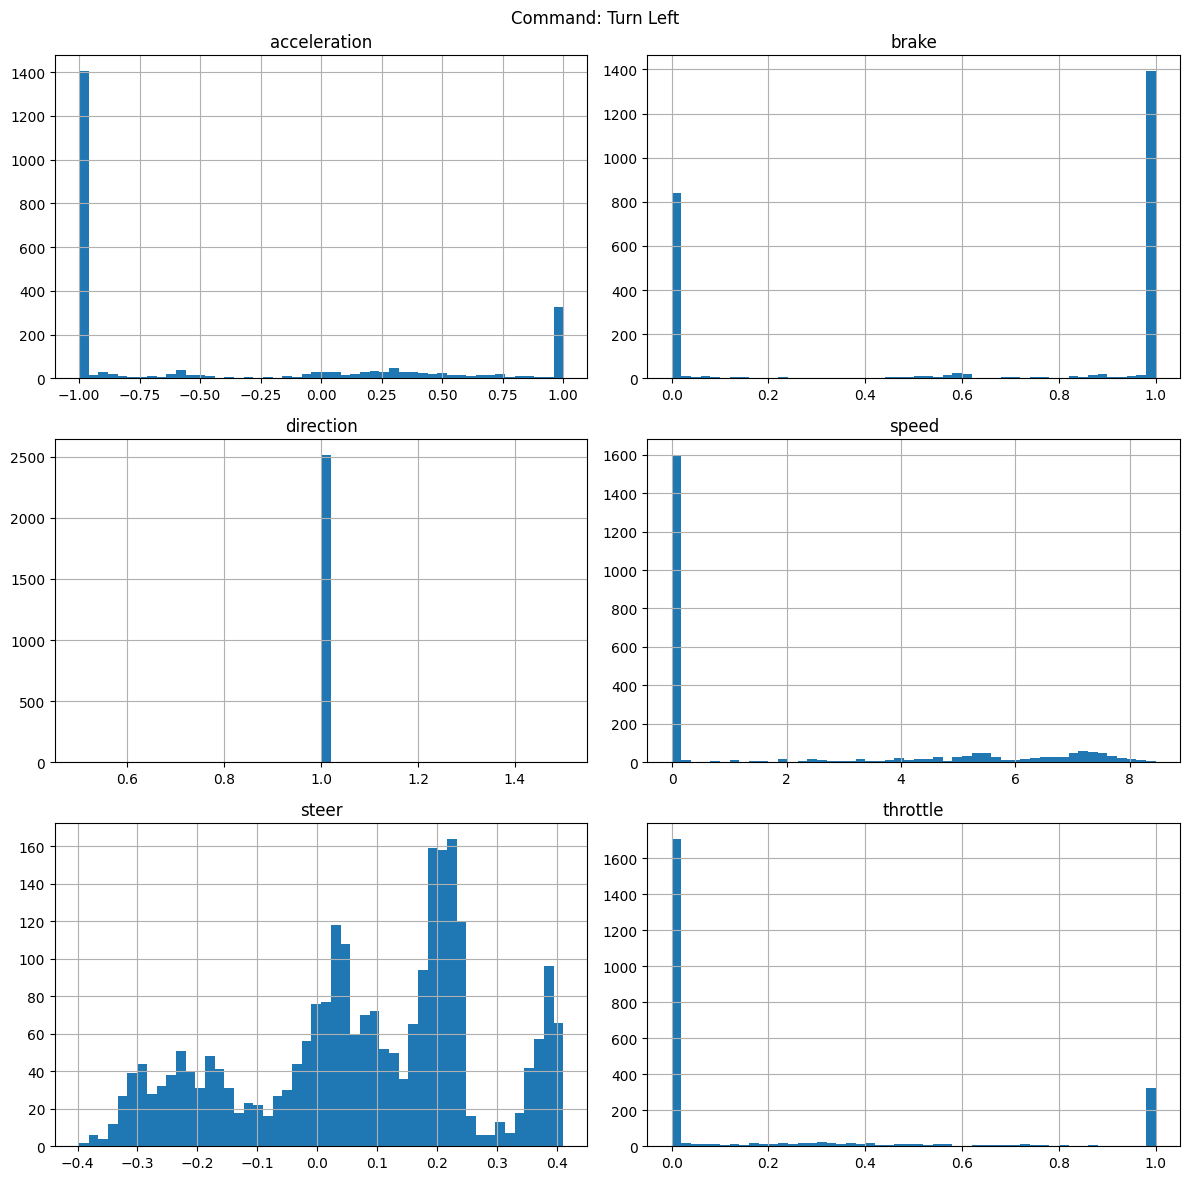

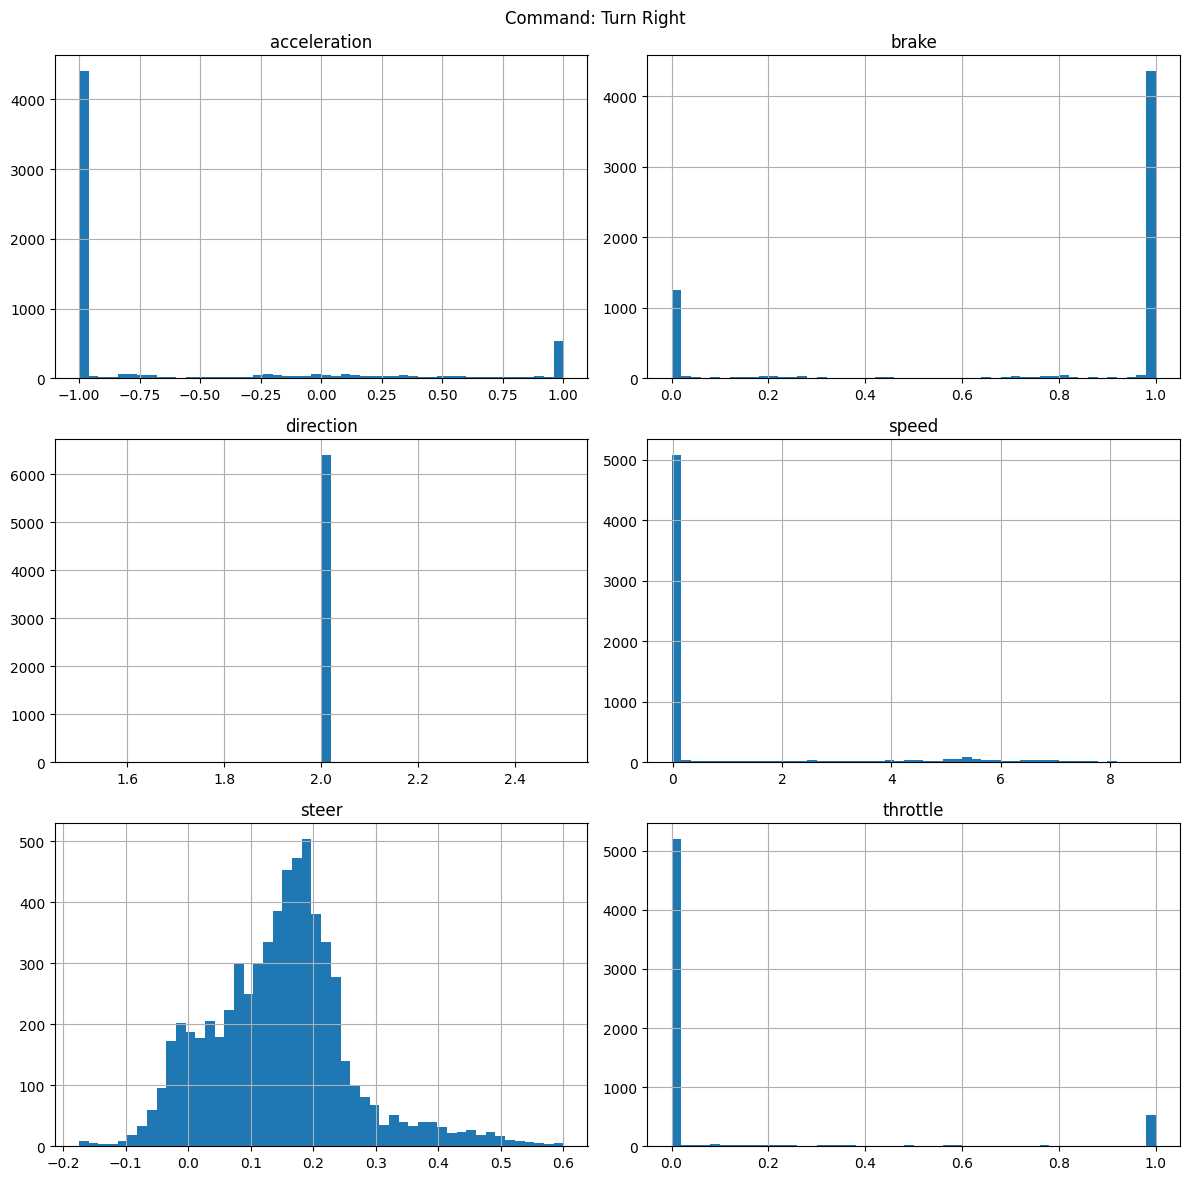

In [15]:
# Plot the distributions w.r.t. the direction; set the title of each plot as the direction
for command in df['command'].unique():
    df[df['command'] == command].hist(figsize=(12, 12), bins=50)
    plt.suptitle(f'Command: {command}')
    plt.tight_layout()
    plt.show()

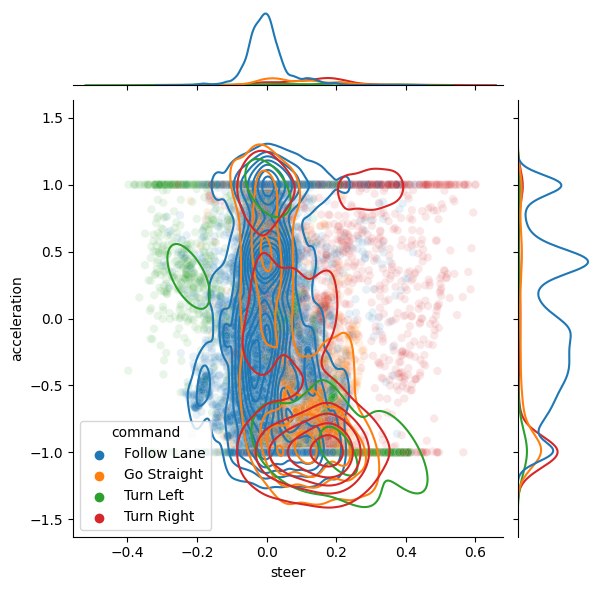

In [16]:
# Now, a 2d distribution plot:
sns.jointplot(data=df, x='steer', y='acceleration', kind='kde', hue='command')
# Add the whole dataset as a scatter plot
sns.scatterplot(data=df, x='steer', y='acceleration', hue='command', alpha=0.1)
plt.show()

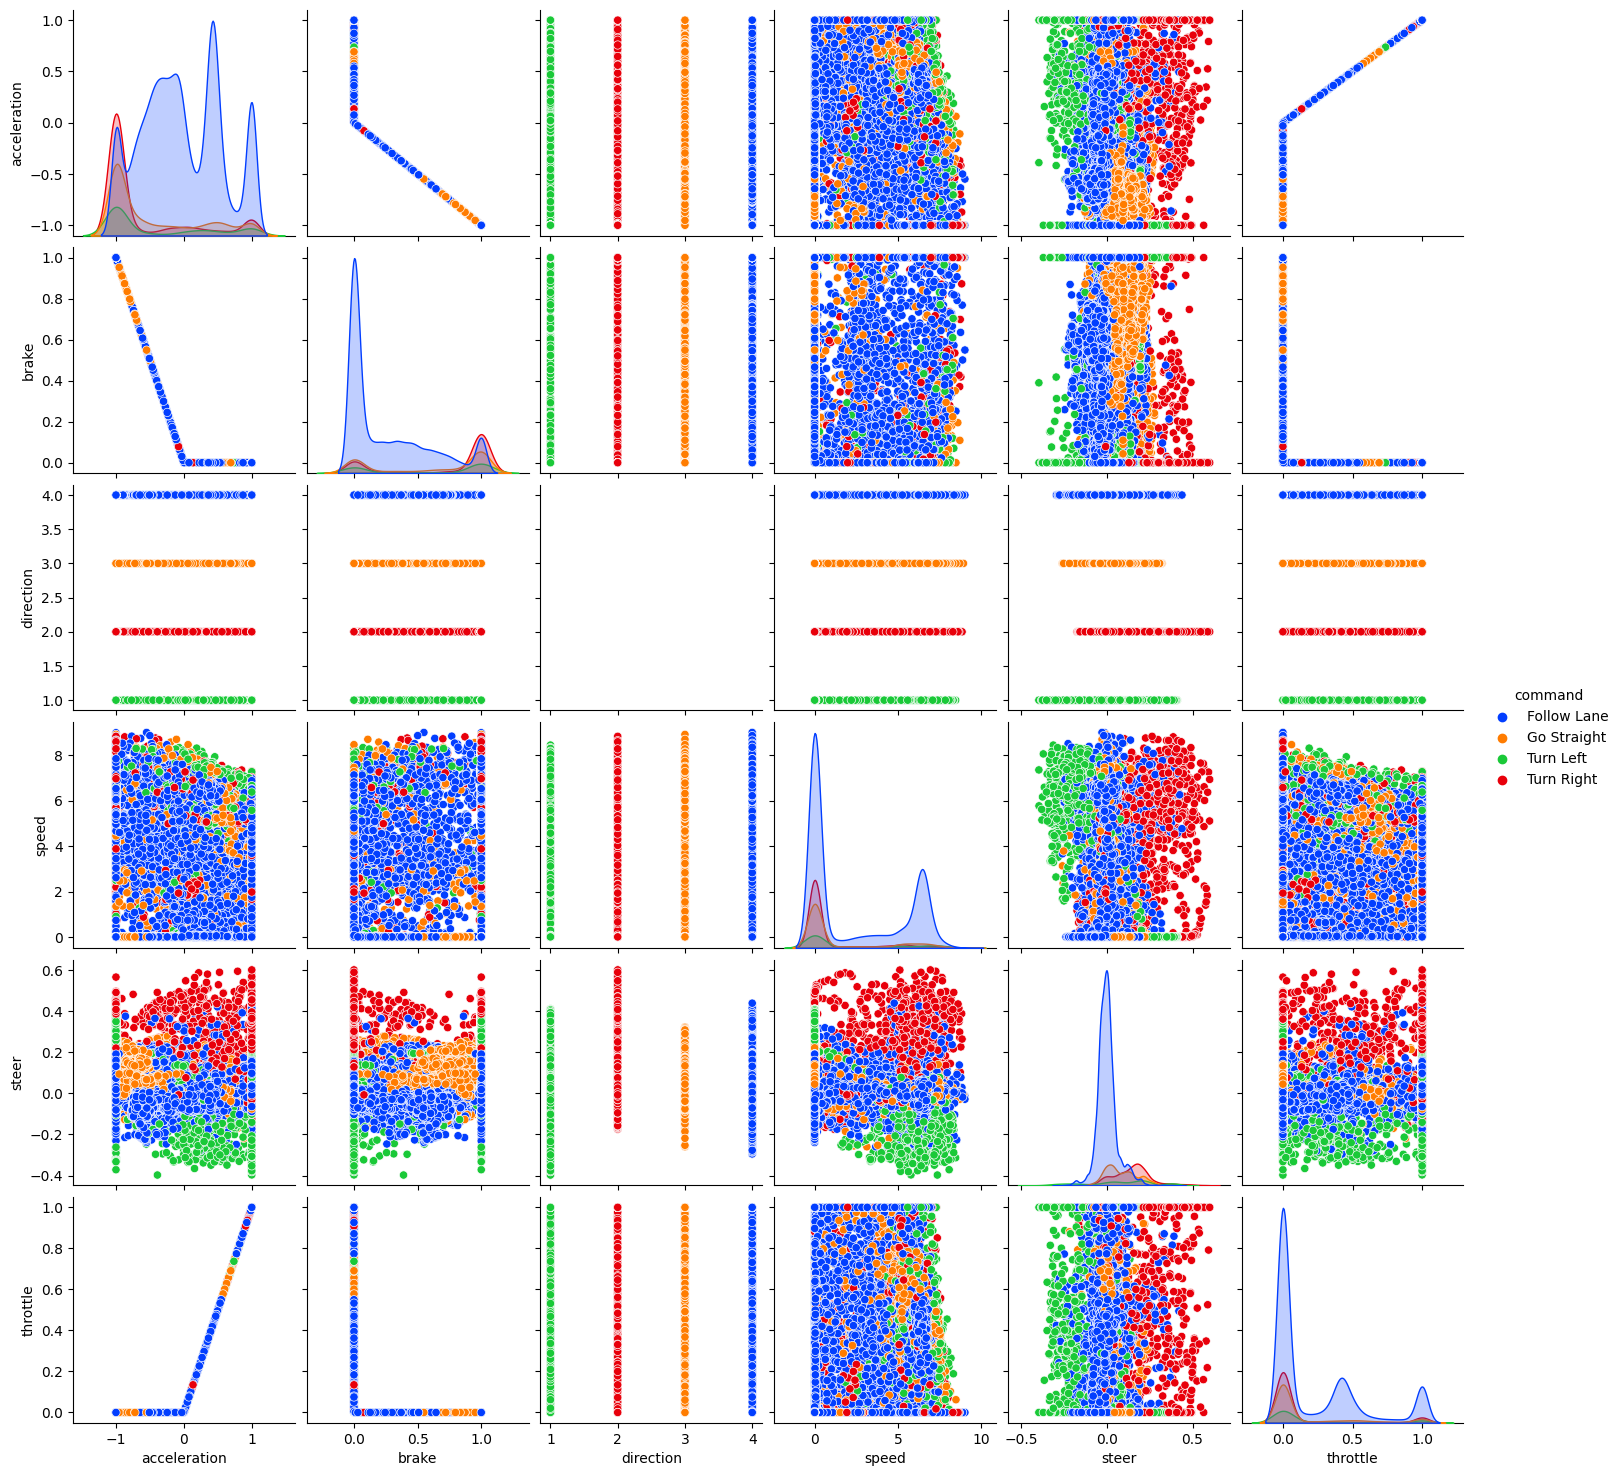

In [17]:
# Do a distribution plot of each column w.r.t. each other
sns.pairplot(data=df, hue='command', palette='bright')
plt.show()

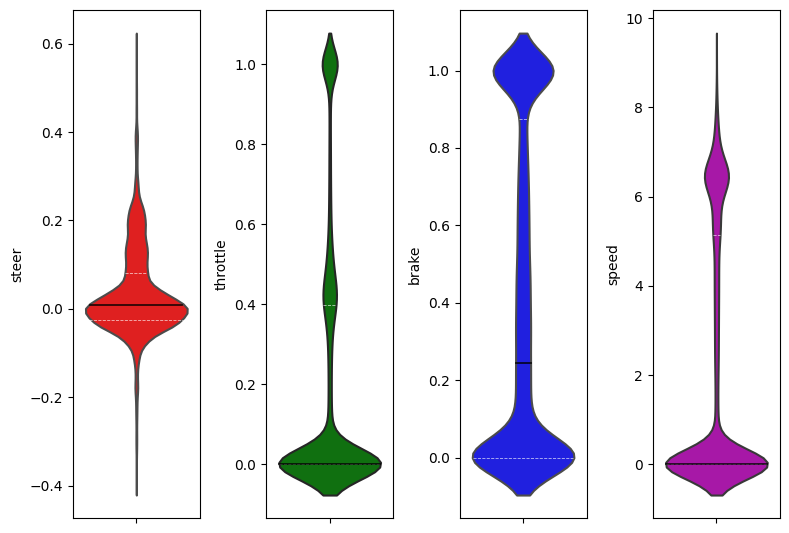

In [35]:
def set_lines(ax):
    for l in ax.lines:
        l.set_linestyle('--')
        l.set_linewidth(0.6)
        l.set_color('white')
        l.set_alpha(0.7)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(1.3)
        l.set_color('black')
        l.set_alpha(0.8)

fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(1, 4)

fig.add_subplot(gs[0, 0])
ax = sns.violinplot(y='steer', data=df, color='r', inner='quartile')
set_lines(ax)

fig.add_subplot(gs[0, 1])
ax = sns.violinplot(y='throttle', data=df, color='g', inner='quartile')
set_lines(ax)

fig.add_subplot(gs[0, 2])
ax = sns.violinplot(y='brake', data=df, color='b', inner='quartile')
set_lines(ax)

fig.add_subplot(gs[0, 3])
ax = sns.violinplot(y='speed', data=df, color='m', inner='quartile')
set_lines(ax)

fig.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

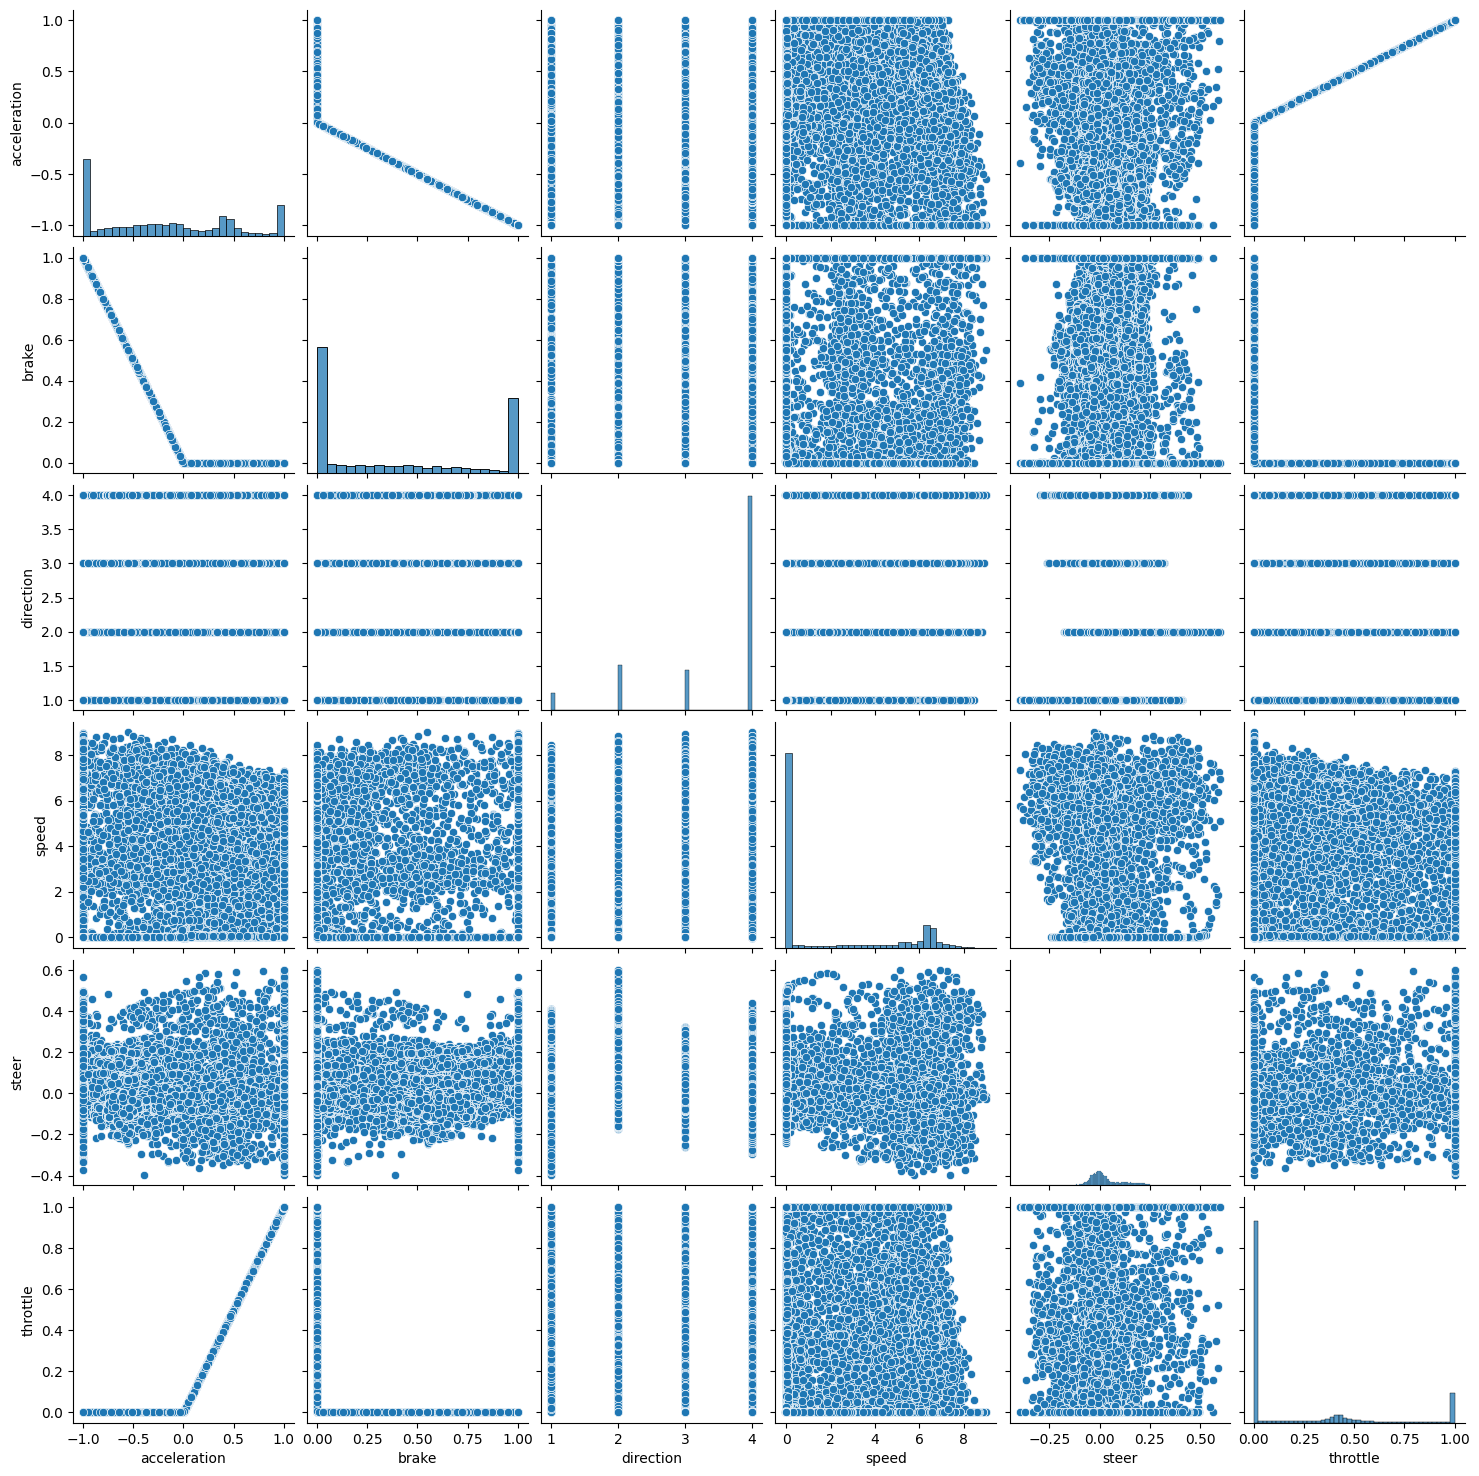

In [18]:
sns.pairplot(data=df)
plt.show()

In [22]:
from sklearn import decomposition

In [23]:
pca = decomposition.PCA(n_components=2)
view = pca.fit_transform(df[['steer', 'acceleration', 'speed']])

view.shape

(45000, 2)

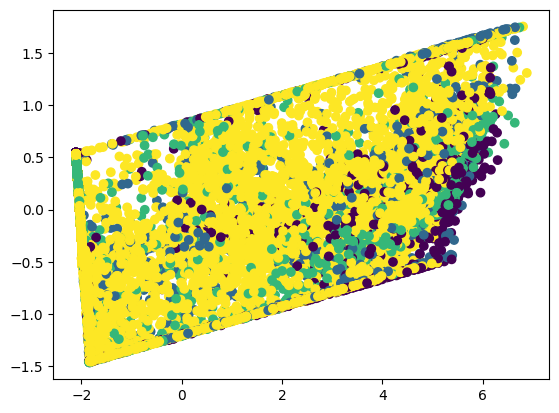

In [27]:
# Plot the 2d data view
plt.scatter(view[:, 0], view[:, 1], c=df['direction'])
plt.show()